# Finite Groups

This notebook runs the modular arithmetic task on any finite group (available in package escnn) using the regular representation acting on the domain of the encoding vector `template`.

In [1]:
import random
import datetime
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from escnn.group import *

# Group Fourier Transform and Inverse

In [2]:
N = 3
group = DihedralGroup(N)
template = np.random.randn(group.order())


def compute_group_fourier_coef(group, template, irrep):
    """Compute the Fourier coefficient of template x at irrep rho.
    
    hat x [rho] = sum_{g in G} x[g] * rho(g).conj().T

    Formula from the Group-AGF paper.
    
    Parameters
    ----------
    group : Group
        The group (escnn object)
    template : np.ndarray, shape=[group.order()]
        The template to compute the Fourier coefficient of.
    irrep : IrreducibleRepresentation
        The irrep (escnn object).

    Returns
    -------
    _ : np.ndarray, shape=[irrep.size, irrep.size]
        The (matrix) Fourier coefficient of template x at irrep rho.
    """
    return sum([template[i_g] * irrep(g).conj().T for i_g, g in enumerate(group.elements)])

def compute_group_fourier_transform(group, template):
    """Compute the group Fourier transform of the template.
    
    Parameters
    ----------
    group : Group
        The group (escnn object)
    template : np.ndarray, shape=[group.order()]
        The template to compute the Fourier transform of.
    
    Returns
    -------
    _: list of np.ndarray, each of shape=[irrep.size, irrep.size]
        A list of (matrix) Fourier coefficients of template at each irrep.
        Since each irrep has a different size (dimension), the (matrix) Fourier
        coefficients have different shapes: the list cannot be concatenated
        into a single array.
    """
    irreps = group.irreps()
    fourier_coefs = []
    for irrep in irreps:
        fourier_coef = compute_group_fourier_coef(group, template, irrep)
        fourier_coefs.append(fourier_coef)
    return fourier_coefs

def compute_group_inverse_fourier_element(group, fourier_transform, g):
    """Compute the inverse Fourier transform at element g.
    
    Using the formula (Wikipedia):
    x(g) = 1/|G| * sum_{rho in irreps} dim(rho) * Tr(rho(g) * hat x[rho])

    Parameters
    ----------
    group : Group (escnn object)
        The group.
    fourier_transform : list of np.ndarray, each of shape=[irrep.size, irrep.size]
        The (matrix) Fourier coefficients of template at each irrep.
    g : GroupElement (escnn object)
        The element of the group to compute the inverse Fourier transform at.

    Returns
    -------
    _ : np.ndarray, shape=[group.order()]
        The inverse Fourier transform at element g.
    """
    irreps = group.irreps()
    inverse_fourier_element = 1/group.order() * sum(
        [irrep.size * np.trace(irrep(g) @ fourier_transform[i]) 
        for i, irrep in enumerate(irreps)])
    return inverse_fourier_element

def compute_group_inverse_fourier_transform(group, fourier_transform):
    """Compute the inverse Fourier transform.
    
    Parameters
    ----------
    group : Group (escnn object)
        The group.
    fourier_transform : list of np.ndarray, each of shape=[irrep.size, irrep.size]
        The (matrix) Fourier coefficients of template at each irrep.
        
    Returns
    -------
    _ : np.ndarray, shape=[group.order()]
        The inverse Fourier transform: a signal over the group.
    """
    return np.array([
        compute_group_inverse_fourier_element(
            group, fourier_transform, g) for g in group.elements])

def compute_group_power_spectrum(group, template):
    """Compute the (group) power spectrum of the template.

    For each irrep rho, the power is given by:
    ||hat x(rho)||_rho = dim(rho) * Tr(hat x(rho)^dagger * hat x(rho))
    where hat x(rho) is the (matrix) Fourier coefficient of template x at irrep rho.

    Parameters
    ----------
    group : Group (escnn object)
        The group.
    template : np.ndarray, shape=[group.order()]
        The template to compute the power spectrum of.

    Returns
    -------
    _ : np.ndarray, shape=[len(group.irreps())]
        The power spectrum of the template.
    """
        
    irreps = group.irreps()

    power_spectrum = np.zeros(len(irreps))
    for i, irrep in enumerate(irreps):
        fourier_coef = compute_group_fourier_coef(group, template, irrep)
        power_spectrum[i] = irrep.size * np.trace(fourier_coef.conj().T @ fourier_coef)  # TODO: check if this is correct 
        # print(f"Power of {irrep.name}: {power_spectrum[i]}, type: {type(power_spectrum[i])}")
    return np.array(power_spectrum)

# Test functions:
for test_irrep in group.irreps():
    fourier_coef = compute_group_fourier_coef(group, template, test_irrep)
    print(f"Fourier coef of {test_irrep.name}: {fourier_coef}", fourier_coef.dtype)

compute_group_power_spectrum(group, template)

#Note: https://groupprops.subwiki.org/wiki/Linear_representation_theory_of_dihedral_groups
# all dihedral groups are ambivalent groups -- every element is conjugate to its inverse. 
# Thus, all the irreducible representations of a dihedral group over the complex numbers can be realized over the real numbers.

Fourier coef of irrep_0,0: [[-1.11261015]] float64
Fourier coef of irrep_1,0: [[-3.28131149]] float64
Fourier coef of irrep_1,1: [[-4.67214437  0.59503575]
 [ 1.9273582  -1.98113133]] float64


array([ 1.23790135, 10.76700507, 59.64518312])

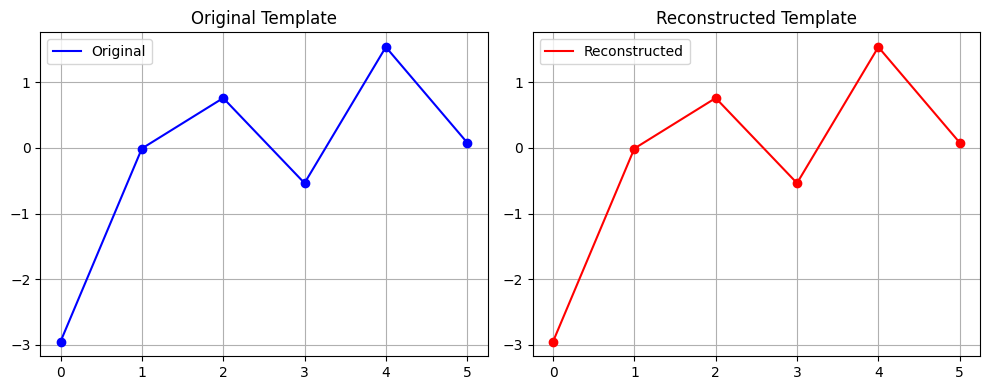

In [3]:
# This is a quick test that tests the Fourier transform and inverse Fourier transform.
ft_template = compute_group_fourier_transform(group, template)

template_rec = compute_group_inverse_fourier_transform(group, ft_template)

plt.figure(figsize=(10, 4))

# Plot original template
plt.subplot(121)
plt.plot(template, 'b-', label='Original')
plt.plot(template, 'bo')
plt.title('Original Template')
plt.grid(True)
plt.legend()

# Plot reconstructed template
plt.subplot(122)
plt.plot(template_rec.real, 'r-', label='Reconstructed') 
plt.plot(template_rec.real, 'ro')
plt.title('Reconstructed Template')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

## Dataset

In [4]:
group.irreps()

[D3|[irrep_0,0]:1, D3|[irrep_1,0]:1, D3|[irrep_1,1]:2]

In [5]:
def generate_fixed_group_template(group):
    """Generate a fixed template for a group, that has non-zero Fourier coefficients 
    only for a few irreps.
    
    Parameters
    ----------
    group : Group (escnn object)
        The group.

    Returns
    -------
    template : np.ndarray, shape=[group.order()]
        The template.
    """
     # TODO: This only works for D3 for now.
    # Generate template array from Fourier spectrum
    spectrum = [np.array([[10.]]), np.array([[10.]]), np.array([[5., 5.], [5., 5.]])]
    # Generate signal from spectrum
    template = compute_group_inverse_fourier_transform(group, spectrum)

    return template

[100. 100. 200.]


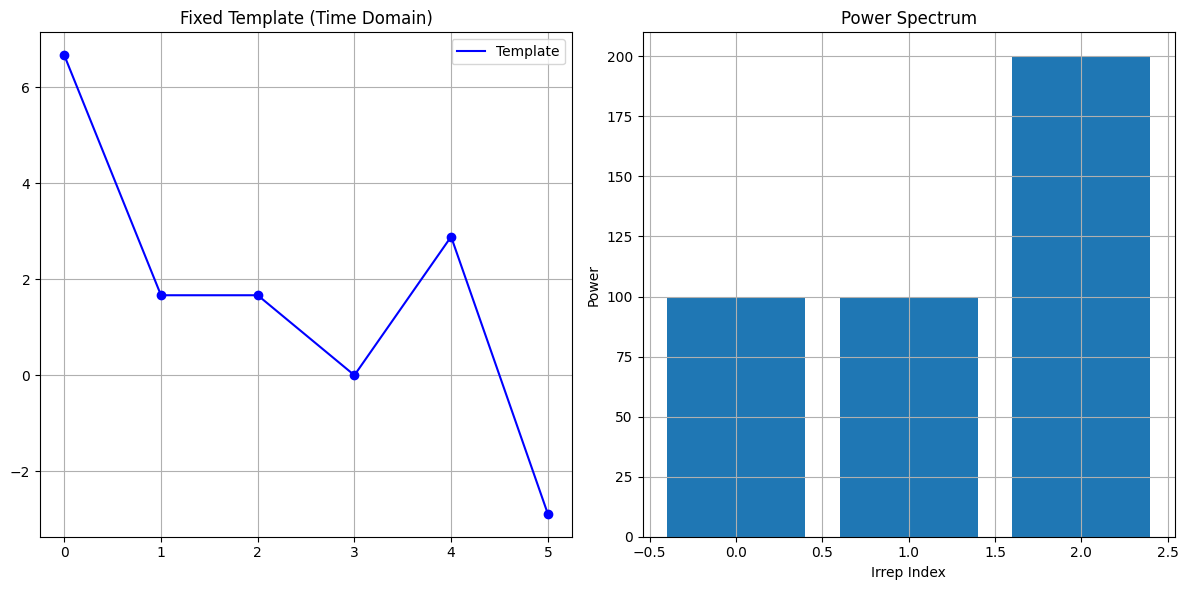

In [6]:
template = generate_fixed_group_template(group)

# Plot the template
plt.figure(figsize=(12, 6))

# Plot template in time domain
plt.subplot(121)
plt.plot(template, 'b-', label='Template')
plt.plot(template, 'bo')
plt.title('Fixed Template (Time Domain)')
plt.grid(True)
plt.legend()

# Plot power spectrum
plt.subplot(122)
ft_template = compute_group_fourier_transform(group, template)
powers = compute_group_power_spectrum(group, template)
print(powers)
plt.bar(range(len(powers)), powers)
plt.title('Power Spectrum')
plt.xlabel('Irrep Index')
plt.ylabel('Power')
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
# TODO: Check if dataset is correctly centered (see paper on generating dataset)
def group_dataset(group, template):
    """Generate a dataset of group elements acting on the template.

    Using the regular representation.
    
    Parameters
    ----------
    group : Group (escnn object)
        The group.
    template : np.ndarray, shape=[group.order()]
        The template to generate the dataset from.

    Returns
    -------
    X : np.ndarray, shape=[group.order()**2, 2, group.order()]
        The dataset of group elements acting on the template.   
    Y : np.ndarray, shape=[group.order()**2, group.order()]
        The dataset of group elements acting on the template.
    """
        
    # Initialize data arrays
    group_order = group.order()
    assert len(template) == group_order, "template must have the same length as the group order"
    n_samples = group_order ** 2
    X = np.zeros((n_samples, 2, group_order))
    Y = np.zeros((n_samples, group_order))
    regular_rep = group.representations["regular"]
    
    idx = 0
    for g1 in group.elements:
        for g2 in group.elements:
            g1_rep = regular_rep(g1)
            g2_rep = regular_rep(g2)
            g12_rep = g1_rep @ g2_rep

            X[idx, 0, :] = g1_rep @ template
            X[idx, 1, :] = g2_rep @ template
            Y[idx, :] = g12_rep @ template
            idx += 1
            
    return X, Y

In [8]:
N = 3
group = DihedralGroup(N)
template = generate_fixed_group_template(group)
X, Y = group_dataset(group, template)
X.shape
Y.shape


(36, 6)

## Architecture

In [9]:
class TwoLayerNet(nn.Module):
    def __init__(self, group, hidden_size, nonlinearity='square', init_scale=1.0, output_scale=1.0):
        super(TwoLayerNet, self).__init__()
        
        # Store dimensions
        self.p = group.order()
        self.hidden_size = hidden_size
        self.nonlinearity = nonlinearity
        self.init_scale = init_scale
        self.output_scale = output_scale
        
        # Initialize parameters 
        self.U = nn.Parameter(
            self.init_scale * torch.randn(hidden_size, self.p) / np.sqrt(2 * self.p))  # First p elements
        self.V = nn.Parameter(
            self.init_scale * torch.randn(hidden_size, self.p) / np.sqrt(2 * self.p))  # Second p elements
        self.W = nn.Parameter(
            self.init_scale * torch.randn(hidden_size, self.p) / np.sqrt(self.p)) # Second layer weights
        print(f"Initialized U with shape {self.U.shape}")
        print(f"Initialized V with shape {self.V.shape}")
        print(f"Initialized W with shape {self.W.shape}")

    def forward(self, x):
        print(f"Input x shape: {x.shape}")
        # First layer (linear and combined)
        x1 = x[:, :self.p] @ self.U.T
        print(f"x1 (x @ U.T) shape: {x1.shape}")
        x2 = x[:, self.p:] @ self.V.T
        print(f"x2 (x @ V.T) shape: {x2.shape}")
        x_combined = x1 + x2
        print(f"x_combined (x1 + x2) shape: {x_combined.shape}")

        # Apply nonlinearity activation
        if self.nonlinearity == 'relu':
            x_combined = torch.relu(x_combined)
            print("Applied ReLU nonlinearity")
        elif self.nonlinearity == 'square':
            x_combined = x_combined**2
            print("Applied square nonlinearity")
        elif self.nonlinearity == 'linear':
            x_combined = x_combined
            print("Applied linear (identity) nonlinearity")
        elif self.nonlinearity == 'tanh':
            x_combined = torch.tanh(x_combined)
            print("Applied tanh nonlinearity")
        elif self.nonlinearity == 'gelu':
            gelu = torch.nn.GELU()
            x_combined = gelu(x_combined)
            print("Applied GELU nonlinearity")
        else:
            raise ValueError(f"Invalid nonlinearity '{self.nonlinearity}' provided.")

        # Second layer (linear)
        x_out = x_combined @ self.W
        print(f"x_out (x_combined @ W) shape: {x_out.shape}")

        # Feature learning scaling
        x_out *= self.output_scale
        print(f"x_out after scaling with output_scale={self.output_scale}: shape {x_out.shape}")
        
        return x_out

## Optimization

In [10]:
def test_accuracy(model, dataloader):
    correct = 0
    total = 0
    print("Starting test_accuracy evaluation...")
    
    with torch.no_grad():  # Disable gradient calculation for evaluation
        for i, (inputs, labels) in enumerate(dataloader):
            inputs = inputs.view(inputs.shape[0], -1)  # Flatten input for FC layers
            #print(f"Batch {i+1}: inputs reshaped")
            outputs = model(inputs)
            #print(f"Batch {i+1}: model forward pass done")
            _, predicted = torch.max(outputs, 1)  # Get the index of the largest value (class)
            _, true_labels = torch.max(labels, 1)  # Get the true class from the one-hot encoding
            correct += (predicted == true_labels).sum().item()
            total += labels.size(0)
            #print(f"Batch {i+1}: accuracy updated (correct={correct}, total={total})")
    
    accuracy = 100 * correct / total
    print(f"Final test accuracy: {accuracy:.2f}%")
    return accuracy

def train(model, dataloader, criterion, optimizer, epochs=100, verbose_interval=10, checkpoint_interval=1000):
    print("Starting training loop...")
    model.train()  # Set the model to training mode
    print("Model set to train mode.")
    loss_history = []  # List to store loss values
    accuracy_history = []
    param_history = []

    for epoch in range(epochs):
        print(f"Epoch {epoch+1} started.")
        running_loss = 0.0
        for batch_idx, (inputs, labels) in enumerate(dataloader):
            inputs = inputs.view(inputs.shape[0], -1)  # Flatten input for FC layers
            #print(f"  Batch {batch_idx+1}: inputs reshaped")

            optimizer.zero_grad()  # Zero gradients
            #print(f"  Batch {batch_idx+1}: optimizer gradients zeroed")
            outputs = model(inputs)  # Forward pass
            #print(f"  Batch {batch_idx+1}: model forward pass done")
            loss = criterion(outputs, labels)  # Compute loss
            #print(f"  Batch {batch_idx+1}: loss computed ({loss.item():.4f})")
            loss.backward()  # Backpropagation
            #print(f"  Batch {batch_idx+1}: backward pass done")
            optimizer.step()  # Update weights
            #print(f"  Batch {batch_idx+1}: optimizer step done")

            running_loss += loss.item()
            #print(f"  Batch {batch_idx+1}: running_loss updated ({running_loss:.4f})")

        # Append the average loss for the epoch to loss_history
        avg_loss = running_loss / len(dataloader)
        loss_history.append(avg_loss)
        print(f"Epoch {epoch+1}: avg_loss appended ({avg_loss:.4f})")

        # Append the accuracy
        model.eval()
        print(f"Epoch {epoch+1}: model set to eval mode for accuracy check")
        accuracy = test_accuracy(model, dataloader)
        accuracy_history.append(accuracy)
        print(f"Epoch {epoch+1}: accuracy appended ({accuracy:.2f}%)")
        model.train()
        print(f"Epoch {epoch+1}: model set back to train mode")

        # Save current model parameters
        current_params = {
            "U": model.U.detach().cpu().clone(),
            "V": model.V.detach().cpu().clone(),
            "W": model.W.detach().cpu().clone()
        }
        param_history.append(current_params)
        print(f"Epoch {epoch+1}: model parameters saved")

        # Print verbose information every `verbose_interval` epochs
        if (epoch + 1) % verbose_interval == 0:
            print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%")

        # Save checkpoint at specified intervals
        if (epoch + 1) % checkpoint_interval == 0:
            date = datetime.datetime.now().strftime("%m%d")
            torch.save(model.state_dict(), f'checkpoint_dihedral{N}_epoch_{epoch+1}_date{date}.pt')
            print(f"Epoch {epoch+1}: checkpoint saved")

    print("Training loop finished.")
    return loss_history, accuracy_history, param_history # Return loss history for plotting

## Plotting functions

In [11]:
def style_axes(ax, numyticks=5, numxticks=5, labelsize=24):
    # Y-axis ticks
    ax.tick_params(axis="y", which="both", bottom=True, top=False,
                   labelbottom=True, left=True, right=False,
                   labelleft=True, direction='out', length=7, width=1.5, pad=8, labelsize=labelsize)
    ax.yaxis.set_major_locator(MaxNLocator(nbins=numyticks))
    
    # X-axis ticks
    ax.tick_params(axis="x", which="both", bottom=True, top=False,
                   labelbottom=True, left=True, right=False,
                   labelleft=True, direction='out', length=7, width=1.5, pad=8, labelsize=labelsize)
    ax.xaxis.set_major_locator(MaxNLocator(nbins=numxticks))

    # Scientific notation formatting
    if ax.get_yscale() == 'linear':
        ax.ticklabel_format(style='sci', axis='y', scilimits=(-2, 2))
    if ax.get_xscale() == 'linear':
        ax.ticklabel_format(style='sci', axis='x', scilimits=(-2, 2))

    ax.xaxis.offsetText.set_fontsize(20)
    ax.grid()

    # Customize spines
    for spine in ["top", "right"]:
        ax.spines[spine].set_visible(False)
    for spine in ["left", "bottom"]:
        ax.spines[spine].set_linewidth(3)

In [12]:
def get_power(points): # TODO: Do we need to generalize this to general groups too?
    p = len(points)
    num_coefficients = (p // 2) + 1
    
    # Perform FFT and calculate power spectrum
    ft = np.fft.fft(points) # Could consider using np.fft.rfft which is designed for real valued input.
    power = np.abs(ft[:num_coefficients])**2 / p
    
    # Double power for frequencies strictly between 0 and Nyquist (Nyquist is not doubled if p is even)
    if p % 2 == 0:  # p is even, Nyquist frequency at index num_coefficients - 1
        power[1:num_coefficients - 1] *= 2
    else:  # p is odd, no Nyquist frequency
        power[1:] *= 2

    # Confirm the power sum approximates the squared norm of points
    total_power = np.sum(power)
    norm_squared = np.linalg.norm(points)**2
    #if not np.isclose(total_power, norm_squared, rtol=1e-3):
        #print(f"Warning: Total power {total_power:.3f} does not match norm squared {norm_squared:.3f}")

    return np.arange(num_coefficients), power

def interpolate(ax, points, color, continuous, alpha=1.0):
    p = len(points)
    if continuous:
        # Perform Fourier Transform
        ft = np.fft.fft(points)
        
        # Keep only non-negative frequencies (first half + Nyquist if p is even)
        num_coefficients = (p // 2) + 1
        ft = ft[:num_coefficients]  # Truncate to keep non-negative frequencies
        
        # Create a dense set of x-values for smooth interpolation
        xs = np.linspace(0, p, 10 * p)  # 10 times more points than the original for smoothness
        curr_val = np.zeros(xs.shape, dtype=complex)
        
        # Use only non-negative frequencies for interpolation
        for freq in range(num_coefficients):
            theta = np.angle(ft[freq])
            r = np.abs(ft[freq]) / p
            # Double amplitude except for DC (freq = 0) and Nyquist (freq = p / 2, when p is even)
            if freq > 0 and (freq < p / 2 or p % 2 != 0):
                r *= 2
            curr_val += r * np.exp(1j * ((2 * np.pi * freq * xs / p) + theta))

        # Plot the real part (since output is real-valued)
        ax.plot(xs, curr_val.real, color=color, alpha=alpha)
    else:
        ax.plot(np.arange(p), points, color=color, alpha=alpha)   

## Gradient Descent Experiment

In [13]:
seed = 0  # or any integer you like
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)  # if using GPU

# Get base vector
template = generate_fixed_group_template(group)
# Mean center template
template -= np.mean(template)

# Generate dataset using numpy
X, Y = group_dataset(group, template)

# Convert to PyTorch tensors
# Flatten input (num_samples, 2*p)
X_tensor = torch.tensor(X, dtype=torch.float32).view(-1, 2 * group.order())  
# Targets (num_samples, p)
Y_tensor = torch.tensor(Y, dtype=torch.float32)

# Create a TensorDataset and DataLoader
dataset = TensorDataset(X_tensor, Y_tensor)
dataloader = DataLoader(dataset, batch_size=len(dataset), shuffle=False)
# dataloader = DataLoader(dataset, batch_size=32, shuffle=False)

# Initialize model
hidden_size = 6 * group.order() 
# TODO :Find what is a good hidden size to use.# group.order()
model = TwoLayerNet(
    group=group, 
    hidden_size=hidden_size, 
    nonlinearity='square', 
    init_scale=1e-2, 
    output_scale=1e0)

# Create loss function
loss = nn.MSELoss()

# Construct optimizer
lr, mom = 0.01, 0.9
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=mom)
# optimizer = optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999))

# Train the model
epochs = 10000 #1000001
loss_history, accuracy_history, param_history = train(
    model, dataloader, loss, optimizer,
    epochs=epochs, verbose_interval=epochs//100, checkpoint_interval=1000)

Initialized U with shape torch.Size([36, 6])
Initialized V with shape torch.Size([36, 6])
Initialized W with shape torch.Size([36, 6])
Starting training loop...
Model set to train mode.
Epoch 1 started.
Input x shape: torch.Size([36, 12])
x1 (x @ U.T) shape: torch.Size([36, 36])
x2 (x @ V.T) shape: torch.Size([36, 36])
x_combined (x1 + x2) shape: torch.Size([36, 36])
Applied square nonlinearity
x_out (x_combined @ W) shape: torch.Size([36, 6])
x_out after scaling with output_scale=1.0: shape torch.Size([36, 6])
Epoch 1: avg_loss appended (8.3333)
Epoch 1: model set to eval mode for accuracy check
Starting test_accuracy evaluation...
Input x shape: torch.Size([36, 12])
x1 (x @ U.T) shape: torch.Size([36, 36])
x2 (x @ V.T) shape: torch.Size([36, 36])
x_combined (x1 + x2) shape: torch.Size([36, 36])
Applied square nonlinearity
x_out (x_combined @ W) shape: torch.Size([36, 6])
x_out after scaling with output_scale=1.0: shape torch.Size([36, 6])
Final test accuracy: 16.67%
Epoch 1: accuracy

KeyboardInterrupt: 

## Plot Loss

In [14]:
# Load the trained model
hidden_size = 6 * group.order() # TODO :Find what is a good hidden size to use.# group.order()
model = TwoLayerNet(group=group, hidden_size=hidden_size, nonlinearity='square', init_scale=1e-2, output_scale=1e0)
model.load_state_dict(torch.load('checkpoint_dihedral3_epoch_4000_date1024.pt'))

Initialized U with shape torch.Size([36, 6])
Initialized V with shape torch.Size([36, 6])
Initialized W with shape torch.Size([36, 6])


<All keys matched successfully>

NameError: name 'loss_history' is not defined

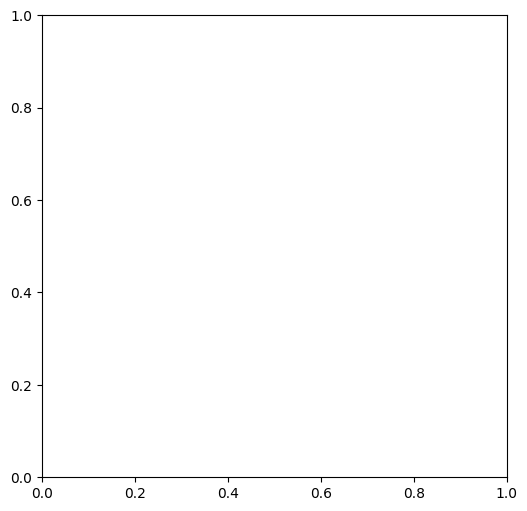

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.plot(list(loss_history), lw=4)

irreps = group.irreps()
powers = compute_group_power_spectrum(group, template)
# Get irreps sorted by descending power
sorted_indices = np.argsort(powers)[::-1]
irreps = irreps[sorted_indices]
powers = powers[sorted_indices]
n_freqs = 7
irreps = irreps[:n_freqs]
powers = powers[:n_freqs]
# lossvals = [np.linalg.norm(template) ** 2 /2 -  np.sum(template)**2/(2*group.order())]
lossvals = [0.66]
for irrep, power in zip(irreps, powers):
    loss_jump = power **2 / group.order()
    print(f"loss_jump: {loss_jump}")
    lossval = lossvals[-1] - loss_jump
    lossvals.append(lossval)

for lossval in lossvals:
    ax.axhline(lossval, alpha=0.3, ls=":", color="xkcd:slate", zorder=-4, lw=2)

ax.set_xscale("log")
ax.set_yscale("log")
# ax.set_xlim(7*1e3, 1e4)
# ax.set_ylim(4*1e-1, 7*1e-1)
ax.set_xlabel('Steps', fontsize=24)
ax.set_ylabel('Train Loss', fontsize=24)

style_axes(ax)
plt.grid(False)
plt.tight_layout()
plt.savefig("loss-without-lines.pdf", bbox_inches="tight")
plt.show()

# Note: jumps are way too big. TODO: Double check theory

## Power Spectrum of output

In [16]:
# === SETTINGS ===
group_order = Y_tensor.shape[1]
num_freqs = 4

# Compute template power spectrum
powers = compute_group_power_spectrum(group, template)
irreps = np.array(group.irreps())

# === Compute power spectrum of template ===

sorted_idx = np.argsort(-powers)
irreps, powers = irreps[sorted_idx], powers[sorted_idx]

# === Theory lines === 

# Color settings
cmap = plt.colormaps.get_cmap('tab20').resampled(num_freqs)
manual_colors = {
    0: 'tab:blue',
    1: 'tab:orange',
    2: 'tab:red',
    3: 'tab:green',
    4: 'tab:brown',
    5: 'tab:purple',
}
colors = [manual_colors.get(i, cmap(i)) for i in range(num_freqs)]

# Compute output power over time (GD)
num_points = 100 # was 1000
steps = np.unique(np.logspace(0, np.log10(len(param_history) - 1), num_points, dtype=int))
powers_over_time = []

for step in steps:
    model.load_state_dict(param_history[step])
    model.eval()
    with torch.no_grad():
        outputs = model(X_tensor)
        outputs_powers = []
        for output in outputs:
            output_powers = compute_group_power_spectrum(group, output.detach().cpu().numpy())
            outputs_powers.append(output_powers)
        outputs_powers = np.array(outputs_powers)
        avg_power = np.mean(outputs_powers, axis=0)
        powers_over_time.append(avg_power)

powers_over_time = np.array(powers_over_time)  # shape: (steps, freqs)

# === PLOTTING ===
fig, ax = plt.subplots(figsize=(6, 7))

for k in range(num_freqs):
    color = colors[k]
    label = fr"$\xi = {k}$" if k in [1, 3, 5] else None
    ax.plot(steps, powers_over_time[:, k], color=color, lw=3, label=label)
    label_agf = 'AGF' if k == 10 else None
    ax.axhline(powers[k], color=color, linestyle='dotted', linewidth=2, alpha=0.5, zorder=-10)

# Labeling and formatting
ax.set_xscale('log')
ax.set_xlim(5e1, 2e6)
ax.set_xticks([1000, 10000, 100000, epochs-1])
ax.set_ylabel("Power", fontsize=24)
ax.set_xlabel("Epochs", fontsize=24)
ax.legend(fontsize=14, title="Frequency", title_fontsize=16, loc='upper right', bbox_to_anchor=(1, 0.9), labelspacing=0.25)

style_axes(ax)
ax.set_xticks([1000, 10000, 100000, epochs-1])
ax.grid(False)
plt.tight_layout()
plt.savefig("fourier_power_only.pdf", bbox_inches="tight")
plt.show()

NameError: name 'param_history' is not defined

## Plot outputs

Input x shape: torch.Size([1, 12])
x1 (x @ U.T) shape: torch.Size([1, 36])
x2 (x @ V.T) shape: torch.Size([1, 36])
x_combined (x1 + x2) shape: torch.Size([1, 36])
Applied square nonlinearity
x_out (x_combined @ W) shape: torch.Size([1, 6])
x_out after scaling with output_scale=1.0: shape torch.Size([1, 6])
Input x shape: torch.Size([1, 12])
x1 (x @ U.T) shape: torch.Size([1, 36])
x2 (x @ V.T) shape: torch.Size([1, 36])
x_combined (x1 + x2) shape: torch.Size([1, 36])
Applied square nonlinearity
x_out (x_combined @ W) shape: torch.Size([1, 6])
x_out after scaling with output_scale=1.0: shape torch.Size([1, 6])
Input x shape: torch.Size([1, 12])
x1 (x @ U.T) shape: torch.Size([1, 36])
x2 (x @ V.T) shape: torch.Size([1, 36])
x_combined (x1 + x2) shape: torch.Size([1, 36])
Applied square nonlinearity
x_out (x_combined @ W) shape: torch.Size([1, 6])
x_out after scaling with output_scale=1.0: shape torch.Size([1, 6])


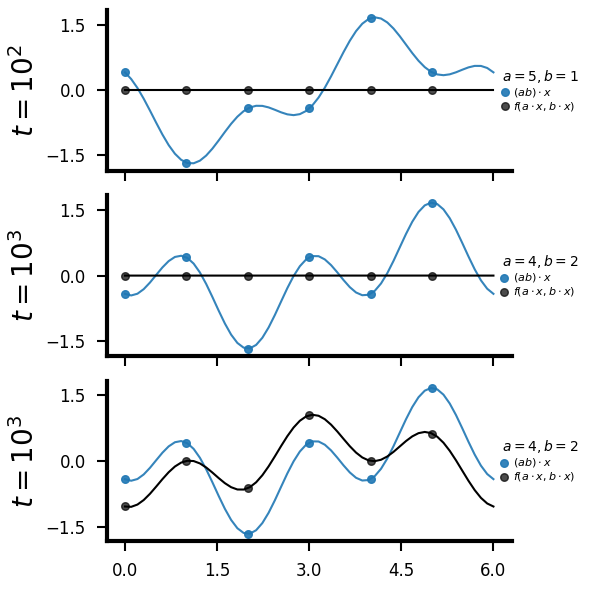

In [ ]:
import matplotlib.pyplot as plt

# Choose time steps to visualize
#steps_to_show = [1000, 10000, 100000, epochs-1]
steps_to_show = [100, 1000, epochs-1]
num_samples = 1  # how many examples to plot per row
p = Y_tensor.shape[1]
x = np.arange(p)

fig, axes = plt.subplots(len(steps_to_show), 1, figsize=(6, 6), sharex=True)

for row, step in enumerate(steps_to_show):
    # Load weights at this step
    model.load_state_dict(param_history[step])
    model.eval()

    indices = np.random.choice(len(Y_tensor), size=num_samples, replace=False)
    with torch.no_grad():
        preds = model(X_tensor[indices]).detach().cpu().numpy()
        truths = Y_tensor[indices].detach().cpu().numpy()

    ax = axes[row]
    for i, idx in enumerate(indices):
        a = idx // p
        b = idx % p
        label_true = r"$(a b) \cdot x$"
        label_pred = r"$f(a \cdot x, b \cdot x)$"

        # Plot ground truth
        interpolate(ax, truths[i], color=f"C{i}", alpha=0.9, continuous=True)
        ax.scatter(x, truths[i], color=f"C{i}", s=30, alpha=0.9, label=label_true)

        # Plot prediction
        interpolate(ax, preds[i], color='k', alpha=1.0, continuous=True)
        ax.scatter(x, preds[i], color='k', s=30, alpha=0.7, label=label_pred)

    style_axes(ax, numyticks=3, labelsize=12)
    ax.grid(False)
    ax.set_ylabel(fr"$t = 10^{{{int(np.log10(step))}}}$", fontsize=20)

    # Only bottom row gets x-ticks
    if row < len(steps_to_show) - 1:
        ax.tick_params(labelbottom=False)

    # ax.legend(loc='best', fontsize=12, title=fr"$a = {a}, b = {b}$", handlelength=0, labelspacing=0.1, title_fontsize=14, frameon=False)
    ax.legend(
        loc='center left',
        bbox_to_anchor=(0.95, 0.5),  # X slightly beyond the right edge, Y centered
        fontsize=8,
        title=fr"$a = {a}, b = {b}$",
        title_fontsize=10,
        handlelength=0,
        labelspacing=0.1,
        frameon=False
    )

# axes[-1].set_xlabel("Output Index", fontsize=20)
plt.tight_layout()
plt.savefig("predictions.pdf", bbox_inches='tight')

## Plot Weights

/tmp/ipykernel_1303575/3117604139.py:96: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  plt.savefig("W-weights.pdf", bbox_inches='tight')
/tmp/ipykernel_1303575/3117604139.py:96: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  plt.savefig("W-weights.pdf", bbox_inches='tight')
/home/nmiolane/anaconda3/envs/gagf/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.canvas.print_figure(bytes_io, **kw)


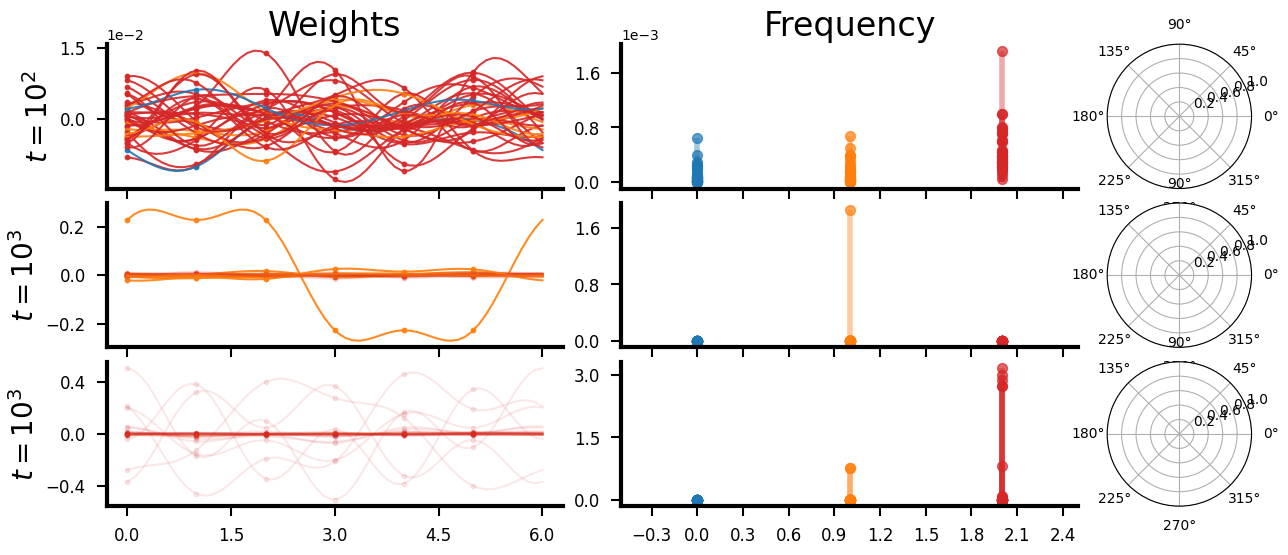

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.gridspec as gridspec

# Steps and corresponding highlighted frequencies

#steps = [1000, 10000, 100000, epochs-1]
steps = [100, 1000, epochs-1]
highlight_freqs_list = [[], [1], [3], [5]]

num_rows, num_cols = len(steps), 3

# Use gridspec to control layout
fig = plt.figure(figsize=(24, 6), constrained_layout=True)
gs = gridspec.GridSpec(num_rows, num_cols, width_ratios=[1.1, 1.1, 2.0], wspace=0.1, hspace=0.1)
axes = np.empty((num_rows, num_cols), dtype=object)

# Create axes
for row in range(num_rows):
    for col in range(num_cols):
        if col == 2: # TODO: what are the phases in our case? 
            ax = fig.add_subplot(gs[row, col], projection='polar')
        else:
            ax = fig.add_subplot(gs[row, col])  # ⬅ no sharex anymore
        axes[row, col] = ax

num_freqs = None
for row, index in enumerate(steps):
    highlight_freqs = highlight_freqs_list[row]
    params = param_history[index]
    W = params['W'].numpy()
    h, p = W.shape

    if num_freqs is None:
        num_freqs = p // 2 + 1
        cmap = plt.colormaps.get_cmap('tab20').resampled(num_freqs)
        colors = [cmap(i) for i in range(num_freqs)]
        manual_colors = {
            0: 'tab:blue',
            1: 'tab:orange',
            2: 'tab:red',
            3: 'tab:green',
            4: 'tab:brown',
            5: 'tab:purple',
        }
        freq_colors = [manual_colors.get(i, cmap(i)) for i in range(num_freqs)]


    # === Column 1: Weights === # TODO UPDATE THEORY HERE
    ax = axes[row, 0]
    for i in range(h): # select one neuron, ie, one parameter vector of length group.order()
        w = W[i, :]
        power = compute_group_power_spectrum(group, w)  # TODO: do we need to square the power?
        dom_idx = np.argmax(power)
        color = freq_colors[dom_idx]
        alpha = 0.9 if not highlight_freqs or dom_idx in highlight_freqs else 0.1
        x = np.linspace(0, group.order() - 1, 500)
        interpolate(ax, w, color=color, continuous=True, alpha=alpha)
        ax.scatter(np.arange(group.order()), w, color=color, s=10, alpha=alpha)
    if row == 0: ax.set_title("Weights", fontsize=24)
    ax.set_ylabel(fr"$t = 10^{{{int(np.log10(index))}}}$", fontsize=20)
    style_axes(ax, numyticks=3, numxticks=5, labelsize=12)
    ax.grid(False)
    if row < num_rows - 1:
        ax.tick_params(labelbottom=False)

    # === Column 2: Frequency Spectrum ===
    ax = axes[row, 1]
    for i in range(h):
        w = W[i, :]
        power = compute_group_power_spectrum(group, w)  # TODO: do we need to square the power?
        for k in range(len(power)):
            color = freq_colors[k]
            ax.vlines(k, 0, power[k], linewidth=4, color=color, alpha=0.4)
            ax.scatter(k, power[k], color=color, s=50, alpha=0.7)
    # ax.axhline(0, color='gray', linewidth=1, linestyle='--', alpha=0.4)
    ax.set_xlim(-0.5, len(power) - 0.5)
    ax.set_xticks(np.arange(len(power)))
    if row == 0: ax.set_title("Frequency", fontsize=24)
    style_axes(ax, numyticks=3, numxticks=11, labelsize=12)
    ax.grid(False)
    if row < num_rows - 1:
        ax.tick_params(labelbottom=False)

    # === Column 3: Phase Polar Plot ===
    ax = axes[row, 2]
    # TODO: Keeping this one blank for now, since we're not sure what phase is in the matrix case.

# Shift polar plots left to reduce whitespace
for row in range(num_rows):
    ax = axes[row, 2]
    pos = ax.get_position()
    ax.set_position([pos.x0 - 0.155, pos.y0, pos.width, pos.height])

plt.savefig("W-weights.pdf", bbox_inches='tight')